In [1]:
import volrpynn.nest as v
import numpy as np
import pyNN.nest as pynn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
parameters = {"tau_syn_I":5,"tau_refrac":0,"v_thresh":-50,"v_rest":-65,"tau_syn_E":5,"v_reset":-65,"tau_m":20,"e_rev_I":-70,"i_offset":0,"cm":1,"e_rev_E":0}
pynn.setup()

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.6/dist-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


0

In [2]:
p1 = pynn.Population(100, pynn.IF_cond_exp(**parameters))
p2 = pynn.Population(100, pynn.IF_cond_exp(**parameters))
proj2 = pynn.Projection(p1, p2, pynn.AllToAllConnector())
p3 = pynn.Population(10, pynn.IF_cond_exp(**parameters))
proj3 = pynn.Projection(p2, p3, pynn.AllToAllConnector())
p1.record(['spikes', 'v'])
p2.record(['spikes', 'v'])
p3.record(['spikes', 'v'])

In [3]:
def simulate(offset):
    for recorder in pynn.simulator.state.recorders:
        recorder.clear()
    pynn.reset()
    p1.set(i_offset=offset)
    pynn.run(50)

def simulate_spikes(offset, weight_function):
    proj2.set(weight=weight_function(offset, p1.size, p2.size))
    proj3.set(weight=weight_function(offset, p2.size, p3.size))
    simulate(offset)
    return (p1.get_data(), p2.get_data(), p3.get_data())

In [4]:
def count_spikes(data):
    return np.array([s.size for s in data.segments[0].spiketrains]).mean()

def simulate_offsets(rates, weight_function):
    return np.array([simulate_spikes(rate, weight_function) for rate in rates])

In [5]:
weight_function = lambda r, x, y: 0.065 / x
xs = np.arange(0, 12, 0.1)
data = simulate_offsets(ct, weight_function)

In [19]:
spikes = np.array([(count_spikes(d1), count_spikes(d2), count_spikes(d3)) for (d1, d2, d3) in data])

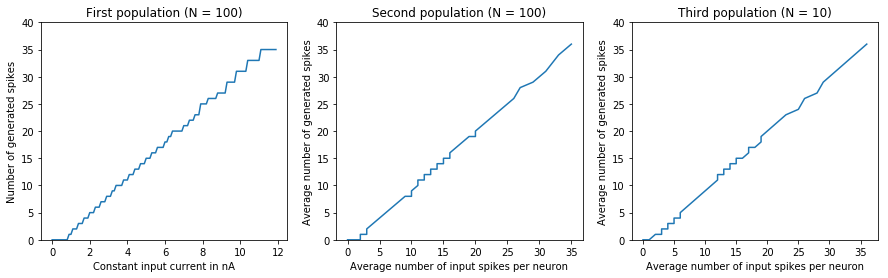

In [66]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(131)
ax.set_ylim(0, 40)
ax.set_title('First population (N = 100)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Constant input current in nA')
plt.plot(xs, spikes[:, 0])
ax2 = plt.subplot(132)
ax2.set_ylim(0, 40)
ax2.set_title('Second population (N = 100)')
plt.ylabel('Average number of generated spikes')
plt.xlabel('Average number of input spikes per neuron')
plt.plot(spikes[:, 0], spikes[:, 1])
ax3 = plt.subplot(133)
ax3.set_ylim(0, 40)
ax3.set_title('Third population (N = 10)')
plt.ylabel('Average number of generated spikes')
plt.xlabel('Average number of input spikes per neuron')
plt.plot(spikes[:, 1], spikes[:, 2])
plt.savefig('spike_rate_mnist.svg')